# Simulate a cluster with ocelot

> ⚠ This feature is currently only available for simulating clusters in Gaia DR3 with PARSEC isochrones. More data types will be added soon!

Ocelot includes many utilities for simulating clusters. They are designed to be flexible and 'hackable' for any science case!

Let's quickly demonstrate how it works.

## Setup

Firstly, we'll need to import the relevant parts of the library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ocelot.simulate import SimulatedCluster, SimulatedClusterParameters
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia
import pyvo

We'll write a little function to plot our clusters:

In [2]:
def plot_on_axes(
    ax, cluster: SimulatedCluster, xlabel: str, ylabel: str, scatter_kwargs: dict
):
    ax.scatter(cluster.cluster[xlabel], cluster.cluster[ylabel], **scatter_kwargs)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.minorticks_on()


def plot_simulated_cluster(cluster: SimulatedCluster, **kwargs):
    fig, ax = plt.subplots(ncols=4, figsize=(12, 3))
    cluster.cluster["bp_rp"] = (
        cluster.cluster["phot_bp_mean_mag"] - cluster.cluster["phot_rp_mean_mag"]
    )
    scatter_kwargs = dict(s=1, color="k")
    scatter_kwargs.update(kwargs)
    plot_on_axes(ax[0], cluster, "l", "b", scatter_kwargs)
    plot_on_axes(ax[1], cluster, "pmra", "pmdec", scatter_kwargs)
    plot_on_axes(ax[2], cluster, "l", "parallax", scatter_kwargs)
    plot_on_axes(ax[3], cluster, "bp_rp", "phot_g_mean_mag", scatter_kwargs)
    ax[3].invert_yaxis()
    fig.tight_layout()
    return fig, ax

## Specifying cluster parameters

ocelot stores parameters about a simulated cluster internally with a class called `SimulatedClusterParameters`. You don't have to, but you can specify a new `SimulatedCluster` with this parameter class.

This has the added bonus that the parameters for your cluster are fully type hinted!

To start, your cluster will need a position **with full 3D position and velocity information,** specified as an astropy SkyCoord.

In [3]:
position = SkyCoord(
    ra=45 * u.deg,
    dec=0 * u.deg,
    distance=1000 * u.pc,
    pm_ra_cosdec=10 * u.mas / u.yr,
    pm_dec=0 * u.mas / u.yr,
    radial_velocity=0 * u.km / u.s,
    frame="icrs"
)

We can then plug this position (and other parameters!) into the SimulatedClusterParameters class.

In [4]:
parameters = SimulatedClusterParameters(
    position=position,
    mass=1000,
    log_age=8.0,
    metallicity=0.2,
    extinction=0.5,
    r_core=2,
    r_tidal=10,

    # By default, ocelot also tries to add a lot more realism to simulated clusters.
    # We'll turn it off for now so that we can demonstrate how it works later!
    photometric_errors=False,
    astrometric_errors=False,
    selection_effects=False,
    binary_stars=False
)

## A basic simulated cluster

Simulating a cluster with these parameters is as easy as doing:

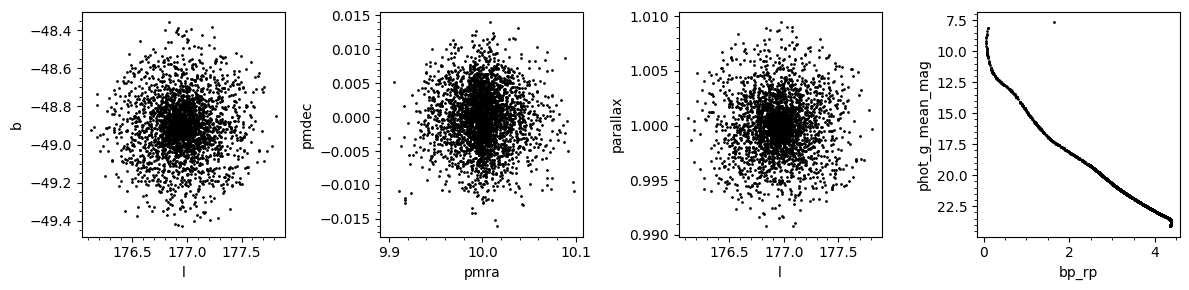

In [5]:
cluster = SimulatedCluster(random_seed=42, parameters=parameters)
cluster.make()
_ = plot_simulated_cluster(cluster)

This successfully simulates the _true_ positions of stars in a simulated cluster. Great!

Note that ocelot also forces you to set a random seed for reproducibility.

The real challenge is to work out what their _observed properties would actually be. This requires three more features that are the real chunky parts of `ocelot.simulate`:

1. Unresolved binary stars
2. Astrometric & photometric errors
3. Selection functions.

## Adding in binary stars

In [6]:
parameters = SimulatedClusterParameters(
    position=position,
    mass=1000,
    log_age=8.0,
    metallicity=0.2,
    extinction=0.5,
    r_core=2,
    r_tidal=10,
    photometric_errors=False,
    astrometric_errors=False,
    selection_effects=False,
)

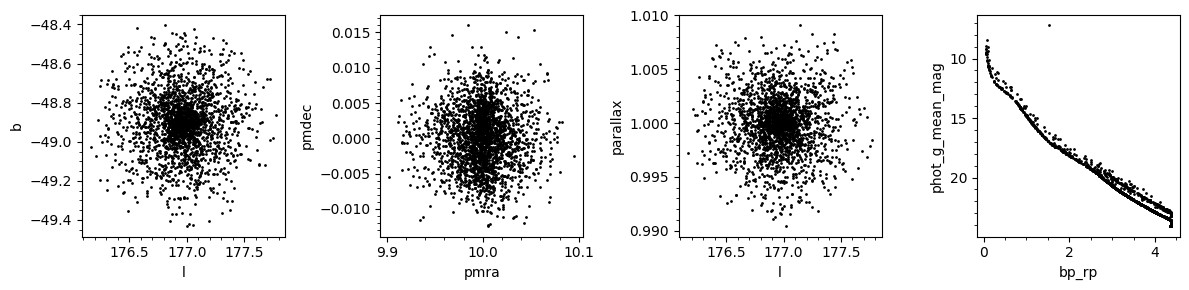

In [7]:
cluster = SimulatedCluster(random_seed=42, parameters=parameters)
cluster.make()
_ = plot_simulated_cluster(cluster)

This code stochastically pairs stars into binaries. Binaries closer than 0.6 arcseconds from each other are assumed to be unresolved by Gaia. (It takes a bit longer to run the first time, as the code uses `numba` to compile some parts of the binary star code.)

For now, just one binary star relation is implemented - the [Moe+17](https://ui.adsabs.harvard.edu/abs/2017ApJS..230...15M/abstract) relationships.

## Adding uncertainties

The astrometry and photometry of real stars is uncertain - often strongly so! Hence, it's also important to simulate the **uncertainties** of cluster astrometry and photometry.

ocelot currently has one method implemented to do this, which relies on using Gaia DR3 data in a data-driven way -- that is, uncertainties are taken from the distribution of uncertainties of real stars in the region around a cluster.

As a stand-in, let's grab some Gaia data in a 0.5 degree radius cone around the cluster:

In [8]:
Gaia.ROW_LIMIT = 100000
query = Gaia.cone_search(parameters.position, radius=0.5*u.deg)
gaia_data = query.get_results().to_pandas().rename(columns={"SOURCE_ID": "source_id"})

We now just pass this data to `SimulatedCluster.make` and it will handle the rest:

In [9]:
parameters = SimulatedClusterParameters(
    position=position,
    mass=1000,
    log_age=8.0,
    metallicity=0.2,
    extinction=0.5,
    r_core=2,
    r_tidal=10,
    selection_effects=False,
    photometric_errors=True
)

Total number of stars: 2526


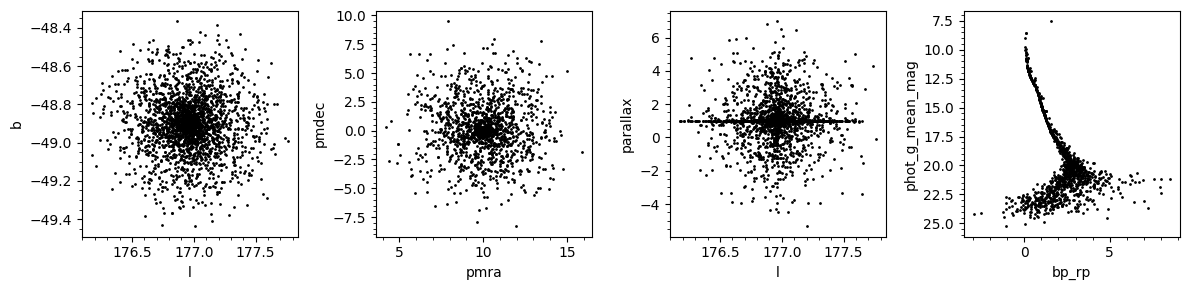

In [10]:
cluster = SimulatedCluster(random_seed=42, parameters=parameters)
cluster.make(gaia_data)
_ = plot_simulated_cluster(cluster)
print("Total number of stars:", cluster.parameters.n_stars)

You'll notice that the proper motion and parallax plots in particular now have MUCH larger scatter.

Seasoned users of Gaia data will notice one final thing that's wrong, though: we have stars fainter than Gaia's magnitude limit, G=21!

## Accounting for selection effects

Our final step is to account for selection effects. Currently, this can only be done in a way that matches Hunt+23's membership lists (which also include a selection effect from a cut defined in Rybizki+22), so we need to get that information for those stars first:

In [11]:
service = pyvo.dal.TAPService("https://dc.zah.uni-heidelberg.de/tap")
source_ids_string = (
    "(" + ", ".join(str(x) for x in gaia_data["source_id"].to_list()) + ")"
)
result = service.search(
    f"SELECT source_id, fidelity_v1 FROM gedr3spur.main WHERE source_id IN {source_ids_string}"
)

fidelities = result.to_table().to_pandas()
gaia_data_with_fidelity = gaia_data.merge(fidelities, on="source_id", how="left")

We can define which stars are in our subsample by defining a `passes_cuts` column:

In [12]:
gaia_data_with_fidelity["passes_cuts"] = np.logical_and.reduce(
    (
        gaia_data_with_fidelity["fidelity_v1"] > 0.5,
        gaia_data_with_fidelity["astrometric_params_solved"] >= 31,
        gaia_data_with_fidelity["phot_g_mean_mag"].notna(),
        gaia_data_with_fidelity["phot_bp_mean_mag"].notna(),
        gaia_data_with_fidelity["phot_rp_mean_mag"].notna(),
    )
)

And now, finally, here is our realistic final cluster

In [13]:
parameters = SimulatedClusterParameters(
    position=position,
    mass=1000,
    log_age=8.0,
    metallicity=0.2,
    extinction=0.5,
    r_core=2,
    r_tidal=10,
)

Total number of stars: 523


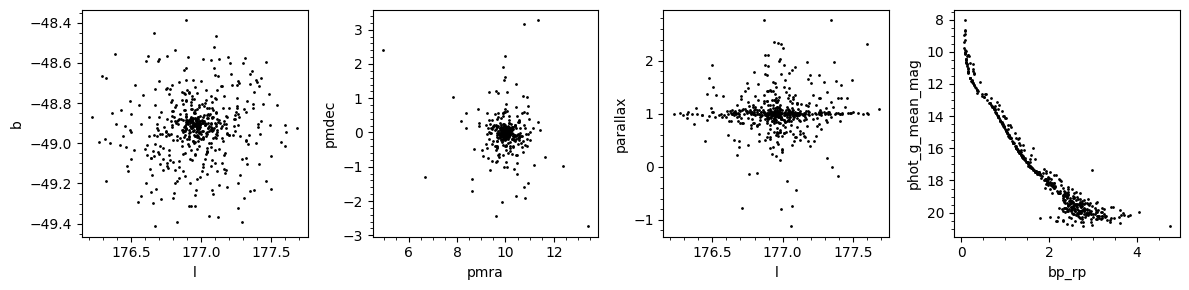

In [14]:
cluster = SimulatedCluster(random_seed=42, parameters=parameters)
cluster.make(gaia_data_with_fidelity)
_ = plot_simulated_cluster(cluster)
print("Total number of stars:", cluster.parameters.n_stars)

Notice how there are **far fewer stars** than before applying the selection effects. This cluster is far enough away (1 kpc) that M dwarfs (which are the most common kind of star!) are too faint to be seen, dramatically reducing the cluster's number count. We don't have that unrealistic huge number of faint sources anymore!

## Other cool things

Finally, it's worth going through a few other features.

1. The SimulatedClusterParameters object can be easily converted to a dictionary for saving.

In [15]:
parameters.to_dict()

{'position': <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
     (45., 0., 1000.)
  (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
     (10., 0., 0.)>,
 'mass': 1000,
 'log_age': 8.0,
 'metallicity': 0.2,
 'extinction': 0.5,
 'r_core': 2,
 'r_tidal': 10,
 'minimum_stars': 1,
 'virial_ratio': 0.5,
 'velocity_dispersion_1d': 424.98063661962993,
 'eta_virial_ratio': 10.0,
 'radial_velocity': 0.0,
 'photometric_errors': True,
 'astrometric_errors': True,
 'astrometric_errors_scale_factor': 1.0,
 'selection_effects': True,
 'visible_stars_only': True,
 'binary_stars': True,
 'binary_star_relation': ocelot.simulate.binaries.MoeDiStefanoMultiplicityRelation,
 'id': 0,
 'r_50': 2.381347656250001,
 'n_stars': 523,
 'ra': 45.0,
 'dec': 0.0,
 'l': 176.96129125564056,
 'b': -48.90264433846198,
 'distance': 1000.0,
 'pmra': 10.0,
 'pmdec': 0.0}

In [19]:
from ocelot.model.differential_reddening import FractalDifferentialReddening

In [20]:
diff = FractalDifferentialReddening(seed=42)

In [23]:
cluster_reference_frame = cluster.parameters.position.skyoffset_frame()

In [33]:
cluster_coords = SkyCoord(
    ra=cluster.cluster["ra"].to_numpy() * u.deg,
    dec=cluster.cluster["dec"].to_numpy() * u.deg,
    distance=(1000 / cluster.cluster["parallax_true"].to_numpy()) * u.pc,
).transform_to(cluster_reference_frame)
cartesian = cluster_coords.cartesian

In [22]:
cluster.cluster.columns

Index(['simulated_id', 'cluster_id', 'simulated_star', 'mass_initial', 'mass',
       't_eff', 'log_g', 'g_true', 'bp_true', 'rp_true', 'a_g', 'a_bp', 'a_rp',
       'companions', 'g_flux', 'bp_flux', 'rp_flux', 'index_primary',
       'matching_star_id', 'phot_g_mean_flux_error', 'phot_bp_mean_flux_error',
       'phot_rp_mean_flux_error', 'pmra_error', 'pmdec_error',
       'parallax_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'ra', 'dec', 'l', 'b', 'pmra', 'pmdec', 'parallax',
       'pmra_true', 'pmdec_true', 'parallax_true', 'radial_velocity_true',
       'bp_rp'],
      dtype='object')

In [ ]:
diff.extinction()